# Import libraries

In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
import time

# Split data to train set, valid set

In [ ]:
dataset_dir = '/kaggle/input/dog-cat-dataset/data'
batch_size = 32
img_height = 224
img_width = 224

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
      dataset_dir,
      label_mode = 'categorical',
      seed=42,
      subset='both',
      validation_split=0.2,
      image_size=(img_height, img_width),
      batch_size=batch_size
)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Using 2000 files for validation.


# Visualize the data

In [ ]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


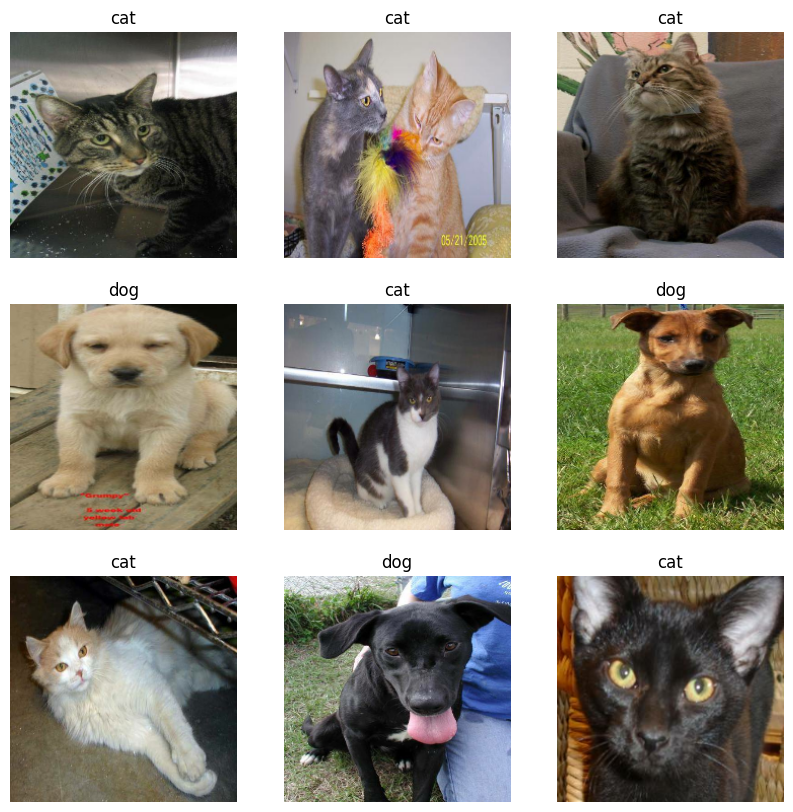

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 2)


# Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

# Create model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
def create_model(input_shape, n_classes, lr=1e-5, fine_tune=0):
    """
    Compiles a model integrated with Resnet50 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = keras.applications.ResNet50(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base(x)
    # Create a new 'top' of the model (i.e. fully-connected layers).
    top_model = GlobalAveragePooling2D()(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=inputs, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model =  create_model((224,224,3), 2, 1e-4, fine_tune=0)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

# Train the model

In [ ]:
!mkdir ./weights

In [ ]:
# Define some callbacks
weights_path = './weights'
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'auto',
                                                 min_delta = 0.025,
                                                 patience = 2,
                                                 factor = 0.1,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 1e-9)

cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    min_delta=0.025,
    verbose=1,
    mode='auto')

cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{weights_path}/model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [ ]:
NUM_EPOCHS = 500
start = time.time()
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=NUM_EPOCHS,
                    callbacks=[cb_early_stopping, cb_checkpoint, reduce_lr])

print('Training time = {:.2f}s'.format((time.time()-start)))

Epoch 1/500
250/250 [==============================] - ETA: 0s - loss: 0.2536 - accuracy: 0.9015
Epoch 1: val_accuracy improved from -inf to 0.97650, saving model to ./weights/model.h5
250/250 [==============================] - 24s 82ms/step - loss: 0.2536 - accuracy: 0.9015 - val_loss: 0.1048 - val_accuracy: 0.9765 - lr: 1.0000e-04
Epoch 2/500
250/250 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9770
Epoch 2: val_accuracy improved from 0.97650 to 0.98150, saving model to ./weights/model.h5
250/250 [==============================] - 20s 78ms/step - loss: 0.0818 - accuracy: 0.9770 - val_loss: 0.0630 - val_accuracy: 0.9815 - lr: 1.0000e-04
Epoch 3/500
250/250 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9830
Epoch 3: val_accuracy improved from 0.98150 to 0.98550, saving model to ./weights/model.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
250/250 [==============================] - 20s 78ms/step - los

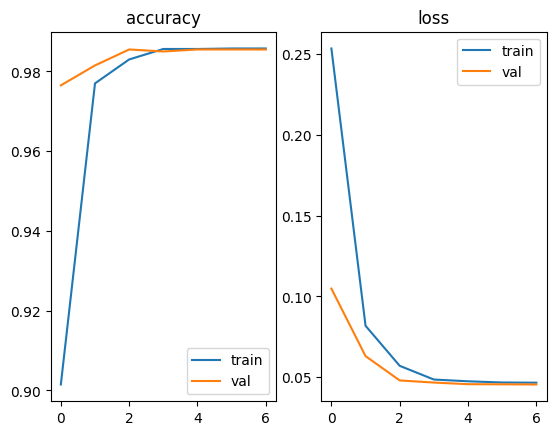

In [ ]:
plt.subplot(121)
plt.title('accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'])

plt.subplot(122)
plt.title('loss')
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])

plt.show()

# Evaluate

In [ ]:
model.load_weights(f'{weights_path}/model.h5')

In [ ]:
model.evaluate(validation_dataset)

63/63 [==============================] - 4s 60ms/step - loss: 0.0479 - accuracy: 0.9855


[0.04793255031108856, 0.9854999780654907]

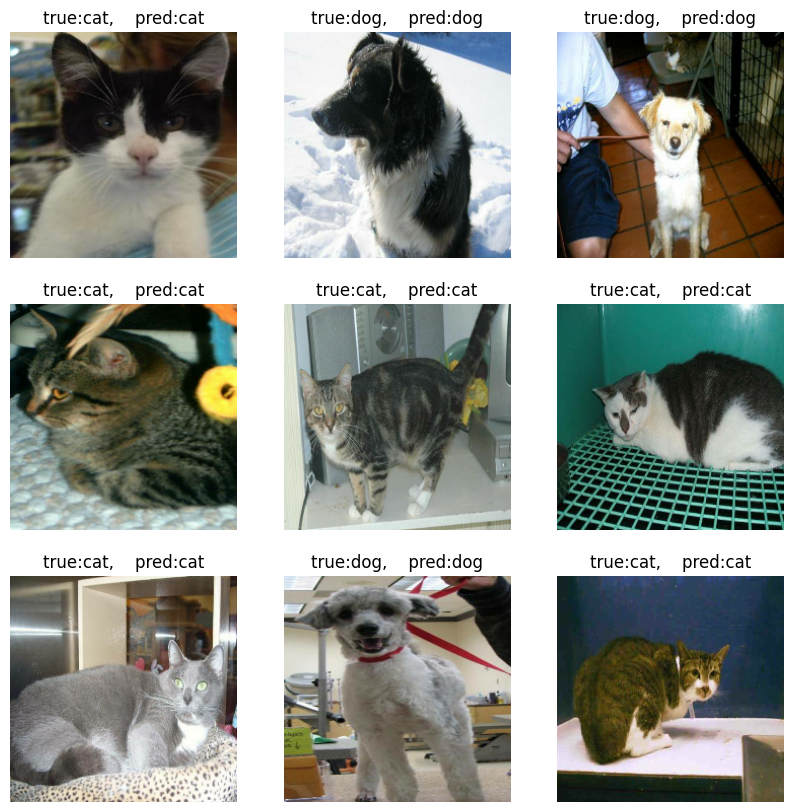

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        i_i = images[i].numpy().astype("uint8").reshape(1, 224, 224, 3)
        y_i = preprocess_input(i_i)
        y_pred = class_names[np.argmax(model.predict(y_i, verbose=0))]
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'true:{class_names[np.argmax(labels[i])]},    pred:{y_pred}')
        plt.axis("off")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch, verbose=0)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

y_true = tf.argmax(correct_labels, axis=1)

In [ ]:
print(classification_report(y_true, predicted_labels, target_names=class_names))

              precision    recall  f1-score   support

         cat       0.98      0.99      0.99       980
         dog       0.99      0.98      0.99      1020

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



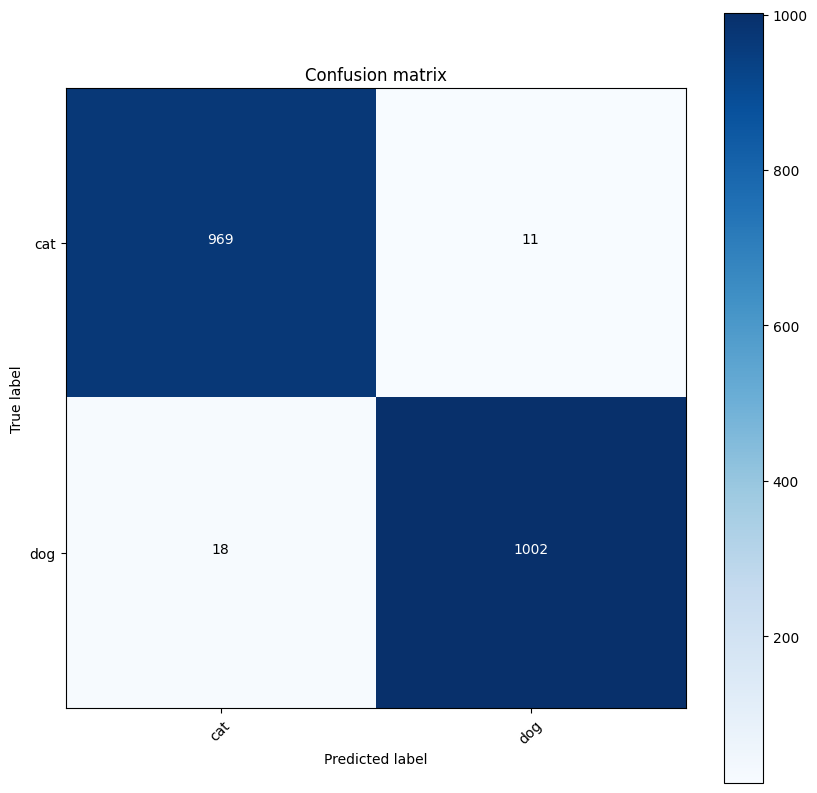

In [ ]:
cnf_matrix = confusion_matrix(y_true, predicted_labels)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show();

# Test one image

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

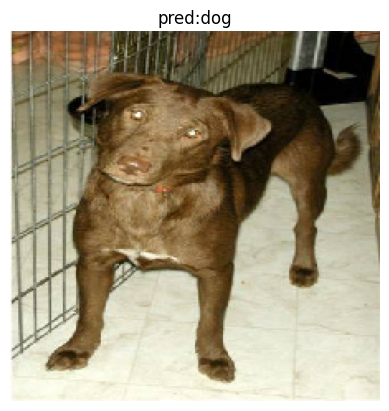

In [ ]:
image_path = "" # @param {type:"string"}
# load an image from file
image = load_img(image_path, target_size=(224, 224))
plt.imshow(image)
plt.axis('off')
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
y_i = preprocess_input(image)
y_pred = class_names[np.argmax(model.predict(y_i,verbose=0))]
plt.title(f'pred:{y_pred}');